[toc]

# Hyperopt 参数调优

## 一个简单的demo

目标：最小化 $y = (x-1)^2$

In [1]:
from hyperopt import tpe, hp, fmin
from matplotlib import pyplot as plt
import numpy as np

f = lambda x: (x-1)**2
space = hp.uniform('x', -2, 2)

best = fmin(
       fn=f, 
       space=space,
       algo=tpe.suggest,
       max_evals=10
)

print(best)

100%|██████████| 10/10 [00:00<00:00, 834.26trial/s, best loss: 0.00917795261691318]
{'x': 1.0958016315983876}


上面结果的可视化：

Text(0.5, 0, 'x')

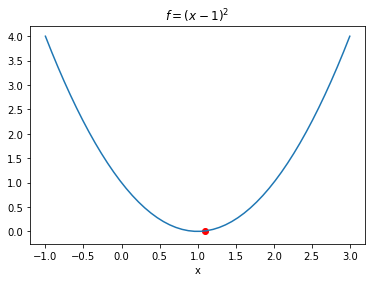

In [2]:
x = np.linspace(-1, 3, 50)
y = f(x)
plt.plot(x, y)
plt.scatter([best['x']], [f(best['x'])], color='red')
plt.title("$f=(x-1)^2$")
plt.xlabel("x")

### fmin 函数

其中执行最小化的 fmin 函数。主要的参数有

- fn : 需要最小化的函数。其接受的参数是从 space 中产生的。fn 可以返回一个 scale，也可以返回一个 dict。如果返回 dict，那么必须要存在 loss 和 status 两个键。其中 loss 代表我们最小化的指标的值。而 status 是 hyperopt.STATUS_OK 或 hyperopt.STATUS_FAIL，分别代表成功和失败。

- space: 定义了参数的搜索空间。

- algo: search algorithm 一般是 `hyperopt.tpe.suggest`，表示 tpe 算法。

- max_evals: 表示最大试验次数

### space

`hyperopt`模块包含一些方便的函数来指定输入参数的范围。我们已经见过`hp.uniform`。最初，这些是随机搜索空间，但随着`hyperopt`更多的学习（因为它从目标函数获得更多反馈），通过它认为提供给它最有意义的反馈，会调整并采样初始搜索空间的不同部分。

以下内容将在本文中使用：

1.  `hp.choice(label, options)` 其中`options`应是 python 列表或元组。
2.  `hp.normal(label, mu, sigma)` 其中`mu`和`sigma`分别是均值和标准差。
3.  `hp.uniform(label, low, high)` 其中`low`和`high`是范围的下限和上限。

其他也是可用的，例如`hp.normal`，`hp.lognormal`，`hp.quniform`，但我们不会在这里使用它们。

注意，我们定义的是一个搜索空间。我们的输入值会从这个搜索空间中随机采样得到。我们使用 `hyperopt.pyll.stochastic` 在搜索空间中采样，然后输出

In [3]:
import hyperopt.pyll.stochastic

space = {
    'x': hp.uniform('x', 0, 1),
    'y': hp.normal('y', 0, 1),
    'name': hp.choice('name', ['alice', 'bob']),
}

print(hyperopt.pyll.stochastic.sample(space))

{'name': 'alice', 'x': 0.8745355712482618, 'y': 0.11084903944158608}


## 通过 Trials 捕获信息

如果我们想在优化的过程中返回一些中间值，可以使用 Trails。trails 的一个基本用法如下。

In [4]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import pprint as pp

fspace = {'x': hp.uniform('x', -5, 5)}


def f(params):
    x = params['x']
    val = x**2
    return val


trials = Trials()
best = fmin(fn=f, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print('best:', best)

print('trials:')
for trial in trials.trials[:2]:
    pp.pprint(trial)

100%|██████████| 50/50 [00:00<00:00, 278.17trial/s, best loss: 2.0128567743701643e-06]
best: {'name': 0, 'x': 0.0014187518367812478, 'y': -0.7203940706071881}
trials:
{'book_time': datetime.datetime(2020, 10, 22, 2, 45, 56, 634000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
          'idxs': {'name': [0], 'x': [0], 'y': [0]},
          'tid': 0,
          'vals': {'name': [0],
                   'x': [0.6436036788820121],
                   'y': [-0.6143791724807585]},
          'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2020, 10, 22, 2, 45, 56, 634000),
 'result': {'loss': 0.4142256954704601, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 0,
 'version': 0}
{'book_time': datetime.datetime(2020, 10, 22, 2, 45, 56, 636000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
          'idxs': {'name': [1], 'x': [1], 'y': [1]},
          'tid': 1,
          'vals': {'name': [1],
                   

- tid是时间 id，即时间步，其值从0到max_evals-1。它随着迭代次数递增。
- 'vals' 中存储的是每次迭代参数的值。'
- loss'是键'result'的值，其给出了该次迭代目标函数的值

### trial 用来返回训练好的模型

trials 的一个重要用途是返回我们训练好的模型，我们每次调用 f 都会训练一个模型，现在我们想要获得这个模型，可以使用 trials。

In [5]:
%reset -f
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp, fmin, Trials, tpe, STATUS_OK
import numpy as np

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1)


def f(params):
    clf = RandomForestClassifier(**params)
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    # 1. 我们在函数的返回中添加 model 来返回我们训练好的模型
    return {'loss': -acc, 'status': STATUS_OK, 'model': clf}

space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'n_estimators': hp.choice('n_estimators', range(1,20)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
}


trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:', best)

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


100%|██████████| 100/100 [00:01<00:00, 54.20trial/s, best loss: -1.0]             
best: {'criterion': 0, 'max_depth': 17, 'max_features': 0, 'n_estimators': 13}


然后，我们就可以使用下面的函数从 trails 中提取出训练好的模型

In [6]:
# from https://stackoverflow.com/a/55389302
def getBestModelfromTrials(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['model']

getBestModelfromTrials(trials)

RandomForestClassifier(max_depth=18, max_features=1, n_estimators=14)

## 一个比较复杂的 demo

In [7]:
%reset -f
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from hyperopt import hp, fmin, Trials, tpe, STATUS_OK
import numpy as np

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3)

def f(params):
    t = params['type']
    del params['type'] # 因为 type 是我们自己添加的一个 key-value。原来的 params 中没有
                        # 因此需要去掉，否则 BernoulliNB(**params)等句在运行时会报错
    if t == 'naive_bayes':
        clf = BernoulliNB(**params)
    elif t == 'svm':
        clf = SVC(**params)
    elif t == 'randomforest':
        clf = RandomForestClassifier(**params)
    elif t == 'knn':
        clf = KNeighborsClassifier(**params)
    else:
        raise Expection("No such type {}".format(t))
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    return {"loss": -acc, "status": STATUS_OK, "model": clf}

space = hp.choice('classifier_type', [
    {
        'type': 'naive_bayes',
        'alpha': hp.uniform('alpha', 0.0, 2.0)
    },
    {
        'type': 'svm',
        'C': hp.uniform('C', 0, 10.0),
        'kernel': hp.choice('kernel', ['linear', 'rbf']),
        'gamma': hp.uniform('gamma', 0, 20.0)
    },
    {
        'type': 'randomforest',
        'max_depth': hp.choice('max_depth', range(1,20)),
        'max_features': hp.choice('max_features', range(1,5)),
        'n_estimators': hp.choice('n_estimators', range(1,20)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
    },
    {
        'type': 'knn',
        'n_neighbors': hp.choice('knn_n_neighbors', range(1,50))
    }
])


trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=10, trials=trials)
print ('best:', best)

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


100%|██████████| 10/10 [00:00<00:00, 66.83trial/s, best loss: -1.0]
best: {'C': 5.841669050720011, 'classifier_type': 1, 'gamma': 0.17022927021333567, 'kernel': 0}


# References
1. [使用 Hyperopt 进行参数调优（译） - 简书](https://www.jianshu.com/p/35eed1567463)

2. [python - How to save the best hyperopt optimized keras models and its weights? - Stack Overflow](https://stackoverflow.com/questions/54273199/how-to-save-the-best-hyperopt-optimized-keras-models-and-its-weights)